In [13]:
! pip install --upgrade xarray zarr gcsfs cftime nc-time-axis
! pip install xclim
! pip install intake-esm

Requirement already up-to-date: xarray in /usr/local/lib/python3.6/dist-packages (0.16.2)
Requirement already up-to-date: zarr in /usr/local/lib/python3.6/dist-packages (2.6.1)
Requirement already up-to-date: gcsfs in /usr/local/lib/python3.6/dist-packages (0.7.1)
Requirement already up-to-date: cftime in /usr/local/lib/python3.6/dist-packages (1.3.0)
Requirement already up-to-date: nc-time-axis in /usr/local/lib/python3.6/dist-packages (1.2.0)


In [66]:
from matplotlib import pyplot as plt
from tqdm import tqdm  # Fancy progress bars for our loops!
import numpy as np
import pandas as pd
import xarray as xr
import zarr
import cftime
import gcsfs
import xclim as xc
from xclim import ensembles
import tqdm
import intake
from google.colab import files
xr.set_options(display_style='html')
import dask
from dask.diagnostics import progress
import fsspec
import seaborn as sns

# this only needs to be created once
gcs = 1 #gcsfs.GCSFileSystem(token='anon')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [15]:
col = intake.open_esm_datastore("https://storage.googleapis.com/cmip6/pangeo-cmip6.json")
# [eid for eid in col.df['experiment_id'].unique() if 'ssp' in eid]


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [54]:
varlist = 'tas','tasmax','tasmin','clt','huss','pr','psl','vas','uas','rsds'

In [16]:
# there is currently a significant amount of data for these runs
expts = ['ssp245']

sl_df = pd.DataFrame(pd.read_csv('/content/modelsources.csv'))
sourcelist = sl_df[sl_df['in_ensemble']=='Yes']['source_id'].values.tolist()

query = dict(
    experiment_id=expts,
    table_id='Amon',
    variable_id='tas',
    member_id = 'r1i1p1f1',
    source_id = sourcelist
)

col_subset = col.search(**query)

In [67]:
def drop_all_bounds(ds):
    drop_vars = [vname for vname in ds.coords
                 if (('_bounds') in vname ) or ('_bnds') in vname]
    return ds.drop(drop_vars)

def open_dset(df):
    # assert len(df) == 1
    ds = xr.open_zarr(fsspec.get_mapper(df.zstore.values[0]), consolidated=True)
    
    if 'lat' in ds.coords:
      ds = ds.sel(
          lat=50, lon=-121,method='nearest')
    else:
      ds = ds.sel(
          latitude=50, longitude=-121,method='nearest')


    ds.coords['year'] = ds.time.dt.year
    ds.coords['time'] = xr.cftime_range(start=str(ds.time.dt.year.values[0]), 
                                    periods=len(ds.time.dt.year.values), 
                                    freq="MS", calendar="noleap")
    ds = ds.sel(time=slice('1950','2100'))
    return drop_all_bounds(ds)

def open_delayed(df):
    return dask.delayed(open_dset)(df)

from collections import defaultdict
dsets = defaultdict(dict)

for group, df in tqdm.tqdm(col_subset.df.groupby(by=['source_id', 'experiment_id'])):
    # print(group)
    dsets[group[0]][group[1]] = open_delayed(df)
    

100%|██████████| 29/29 [00:00<00:00, 2682.19it/s]


In [68]:
with progress.ProgressBar():
    dsets_ = dask.compute(dict(dsets))[0]

[########################################] | 100% Completed |  9.8s


In [19]:
# calculate global means

def get_lat_name(ds):
    for lat_name in ['lat', 'latitude']:
        if lat_name in ds.coords:
            return lat_name
    raise RuntimeError("Couldn't find a latitude coordinate")

def global_mean(ds):
    lat = ds[get_lat_name(ds)]
    weight = np.cos(np.deg2rad(lat))
    weight /= weight.mean()
    other_dims = set(ds.dims) - {'time'}
    return (ds * weight).mean(other_dims)

In [20]:
expt_da = xr.DataArray(expts, dims='experiment_id', name='experiment_id',
                       coords={'experiment_id': expts})

dsets_aligned = {}

for k, v in tqdm.tqdm(dsets_.items()):
    expt_dsets = v.values()
    if any([d is None for d in expt_dsets]):
        print(f"Missing experiment for {k}")
        continue

    
    for ds in expt_dsets:
        ds.coords['year'] = ds.time.dt.year

    # workaround for
    # https://github.com/pydata/xarray/issues/2237#issuecomment-620961663
    dsets_ann_mean = [v[expt]
                      for expt in expts]

    # align everything with the 4xCO2 experiment
    dsets_aligned[k] = xr.concat(dsets_ann_mean, join='outer',
                                 dim='historical')


100%|██████████| 29/29 [00:00<00:00, 153.45it/s]


In [21]:
with progress.ProgressBar():
    dsets_aligned_ = dask.compute(dsets_aligned)[0]

[########################################] | 100% Completed | 45.4s


In [24]:
source_ids = list(dsets_aligned_.keys())
source_da = xr.DataArray(source_ids, dims='source_id', name='source_id',
                         coords={'source_id': source_ids})

big_ds = xr.concat([ds.reset_coords(drop=True)
                    for ds in dsets_aligned_.values()],
                    dim=source_da)

big_ds

<xarray.Dataset>
Dimensions:    (bnds: 2, historical: 1, source_id: 29, time: 1032)
Coordinates:
  * source_id  (source_id) <U13 'ACCESS-CM2' 'ACCESS-ESM1-5' ... 'TaiESM1'
  * bnds       (bnds) float64 1.0 2.0
  * time       (time) object 2015-01-01 00:00:00 ... 2100-12-01 00:00:00
Dimensions without coordinates: historical
Data variables:
    tas        (source_id, historical, time) float32 278.6 275.7 ... 287.0 284.9
Attributes:
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            ScenarioMIP
    branch_method:          standard
    branch_time_in_child:   60265.0
    branch_time_in_parent:  60265.0
    cmor_version:           3.4.0
    creation_date:          2019-11-08T03:14:39Z
    data_specs_version:     01.00.30
    experiment:             update of RCP4.5 based on SSP2
    experiment_id:          ssp245
    external_variables:     areacella
    forcing_index:          1
    frequency:              mon
    further_info_url:       https://furtherinfo.es-doc.org/CMIP6.CSIRO-ARCCSS...
    grid:                   native atmosphere N96 grid (144x192 latxlon)
    grid_label:             gn
    history:                2019-11-08T03:14:39Z ; CMOR rewrote data to be co...
    initialization_index:   1
    institution:            CSIRO (Commonwealth Scientific and Industrial Res...
    institution_id:         CSIRO-ARCCSS
    license:                CMIP6 model data produced by CSIRO is licensed un...
    mip_era:                CMIP6
    nominal_resolution:     250 km
    notes:                  Exp: CM2-ssp245; Local ID: bk882; Variable: tas (...
    parent_activity_id:     CMIP
    parent_experiment_id:   historical
    parent_mip_era:         CMIP6
    parent_source_id:       ACCESS-CM2
    parent_time_units:      days since 1850-01-01
    parent_variant_label:   r1i1p1f1
    physics_index:          1
    product:                model-output
    realization_index:      1
    realm:                  atmos
    run_variant:            forcing: GHG, Oz, SA, Sl, Vl, BC, OC, (GHG = CO2,...
    source:                 ACCESS-CM2 (2019): \naerosol: UKCA-GLOMAP-mode\na...
    source_id:              ACCESS-CM2
    source_type:            AOGCM
    status:                 2020-01-26;created; by gcs.cmip6.ldeo@gmail.com
    sub_experiment:         none
    sub_experiment_id:      none
    table_id:               Amon
    table_info:             Creation Date:(30 April 2019) MD5:e14f55f257cceaf...
    title:                  ACCESS-CM2 output prepared for CMIP6
    tracking_id:            hdl:21.14100/5539b9f2-92df-4832-9963-6db728b08676
    variable_id:            tas
    variant_label:          r1i1p1f1
    version:                v20191108

### Ensemble and Percentiles

In [25]:
# from here the objective is to clean up the xarray and place it in an ensemble 
# where it can be cut for the percentiles

big_ds_lite = big_ds.sel(time=slice('2020','2024'))

vari = list(big_ds_lite.data_vars.keys())[0]
print(vari)

x = getattr(big_ds_lite, 'tas')
ens = ensembles.create_ensemble(x)

tas


<xarray.Dataset>
Dimensions:      (historical: 1, realization: 29, time: 60)
Coordinates:
    source_id    (realization) <U13 'ACCESS-CM2' 'ACCESS-ESM1-5' ... 'TaiESM1'
  * time         (time) datetime64[ns] 2020-01-01 2020-02-01 ... 2024-12-01
  * realization  (realization) int64 0 1 2 3 4 5 6 7 ... 21 22 23 24 25 26 27 28
Dimensions without coordinates: historical
Data variables:
    tas          (realization, historical, time) float32 277.5 278.5 ... 284.1

In [ ]:
length = ens.tas.coords['source_id'].values

for i in range(0,len(length),1):
  print(i)
  print(ens.where(ens.tas[i][0].values<1).tas[i][0].values)

In [27]:
percentile_list = [15, 50, 85]
ens_perc = ensembles.ensemble_percentiles(ens, values=percentile_list, split=False)
ens_stats = ensembles.ensemble_mean_std_max_min(ens)

/usr/local/lib/python3.6/dist-packages/xclim/ensembles/_base.py:241: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  output_sizes={"percentiles": len(values)},


In [64]:
pdict = dict()

for k in percentile_list:
  print(k)
  pdict.update({k:ens_perc.tas.sel(percentiles=k)[0]})


15
50
85


In [59]:
# ens_list = []
percentile_dict = dict(((k, ens_perc.tas.sel(percentiles=k)[0]) for k in percentile_list))
percentile_dict[85]

<xarray.DataArray 'tas' (time: 60)>
array([282.45987701, 282.38452911, 283.33872223, 284.62631989,
       287.57269287, 290.9486618 , 294.22745514, 293.79867554,
       292.02854919, 288.38551331, 285.50363922, 283.92041779,
       282.78455353, 282.06958008, 282.63258362, 284.02500153,
       287.12424469, 291.29420471, 293.99206543, 293.98568726,
       291.7668457 , 288.9839859 , 285.09924316, 283.5274353 ,
       282.61386108, 282.46541595, 282.74680328, 284.0918045 ,
       287.51318359, 292.06022644, 294.81394958, 294.33776093,
       291.58998108, 288.29393005, 285.54602051, 283.17845917,
       282.21800995, 281.7533493 , 282.55360413, 284.48799896,
       286.83708191, 290.95534515, 294.52281952, 294.12110901,
       292.16403961, 289.02233124, 285.96361542, 283.93847656,
       282.25036621, 282.31950378, 282.56732941, 284.73835754,
       287.85710144, 291.20152283, 295.04785919, 294.7412796 ,
       292.17987823, 288.30548859, 285.07395172, 283.45046234])
Coordinates:
  * time         (time) datetime64[ns] 2020-01-01 2020-02-01 ... 2024-12-01
    percentiles  int64 85
Attributes:
    cell_measures:  area: areacella
    cell_methods:   area: time: mean
    comment:        near-surface (usually, 2 meter) air temperature
    history:        2019-11-08T03:14:38Z altered by CMOR: Treated scalar dime...
    long_name:      Near-Surface Air Temperature
    standard_name:  air_temperature
    units:          K
    xclim_history:  2019-11-08T03:14:38Z altered by CMOR: Treated scalar dime...

<xarray.DataArray 'tas' (time: 60)>
array([277.55558777, 277.87854004, 279.68683624, 281.43180084,
       284.75041199, 288.18489838, 290.32964325, 290.63773346,
       288.25138092, 284.29403687, 281.63935089, 278.19997406,
       277.56331635, 278.25647736, 279.21234131, 281.29595184,
       284.66308594, 288.36012268, 290.63769531, 291.41040802,
       288.89396667, 284.8992691 , 282.34860229, 278.8815155 ,
       279.03321838, 278.84169006, 279.4227066 , 281.4196167 ,
       284.85030365, 288.71652222, 290.34226227, 291.36769104,
       287.8506546 , 284.49557495, 281.30169678, 279.27999878,
       277.41726685, 277.81163788, 277.86963654, 281.25018311,
       284.58675385, 287.69451904, 290.48230743, 290.58422089,
       288.41972351, 284.41694641, 280.94192505, 279.27690887,
       277.90468597, 277.44685364, 278.40964508, 281.49593353,
       284.3734436 , 287.39519501, 290.44612885, 290.80706787,
       287.43497467, 284.39214325, 280.35582733, 279.44572449])
Coordinates:
  * time         (time) datetime64[ns] 2020-01-01 2020-02-01 ... 2024-12-01
    percentiles  int64 15
Attributes:
    cell_measures:  area: areacella
    cell_methods:   area: time: mean
    comment:        near-surface (usually, 2 meter) air temperature
    history:        2019-11-08T03:14:38Z altered by CMOR: Treated scalar dime...
    long_name:      Near-Surface Air Temperature
    standard_name:  air_temperature
    units:          K
    xclim_history:  2019-11-08T03:14:38Z altered by CMOR: Treated scalar dime...

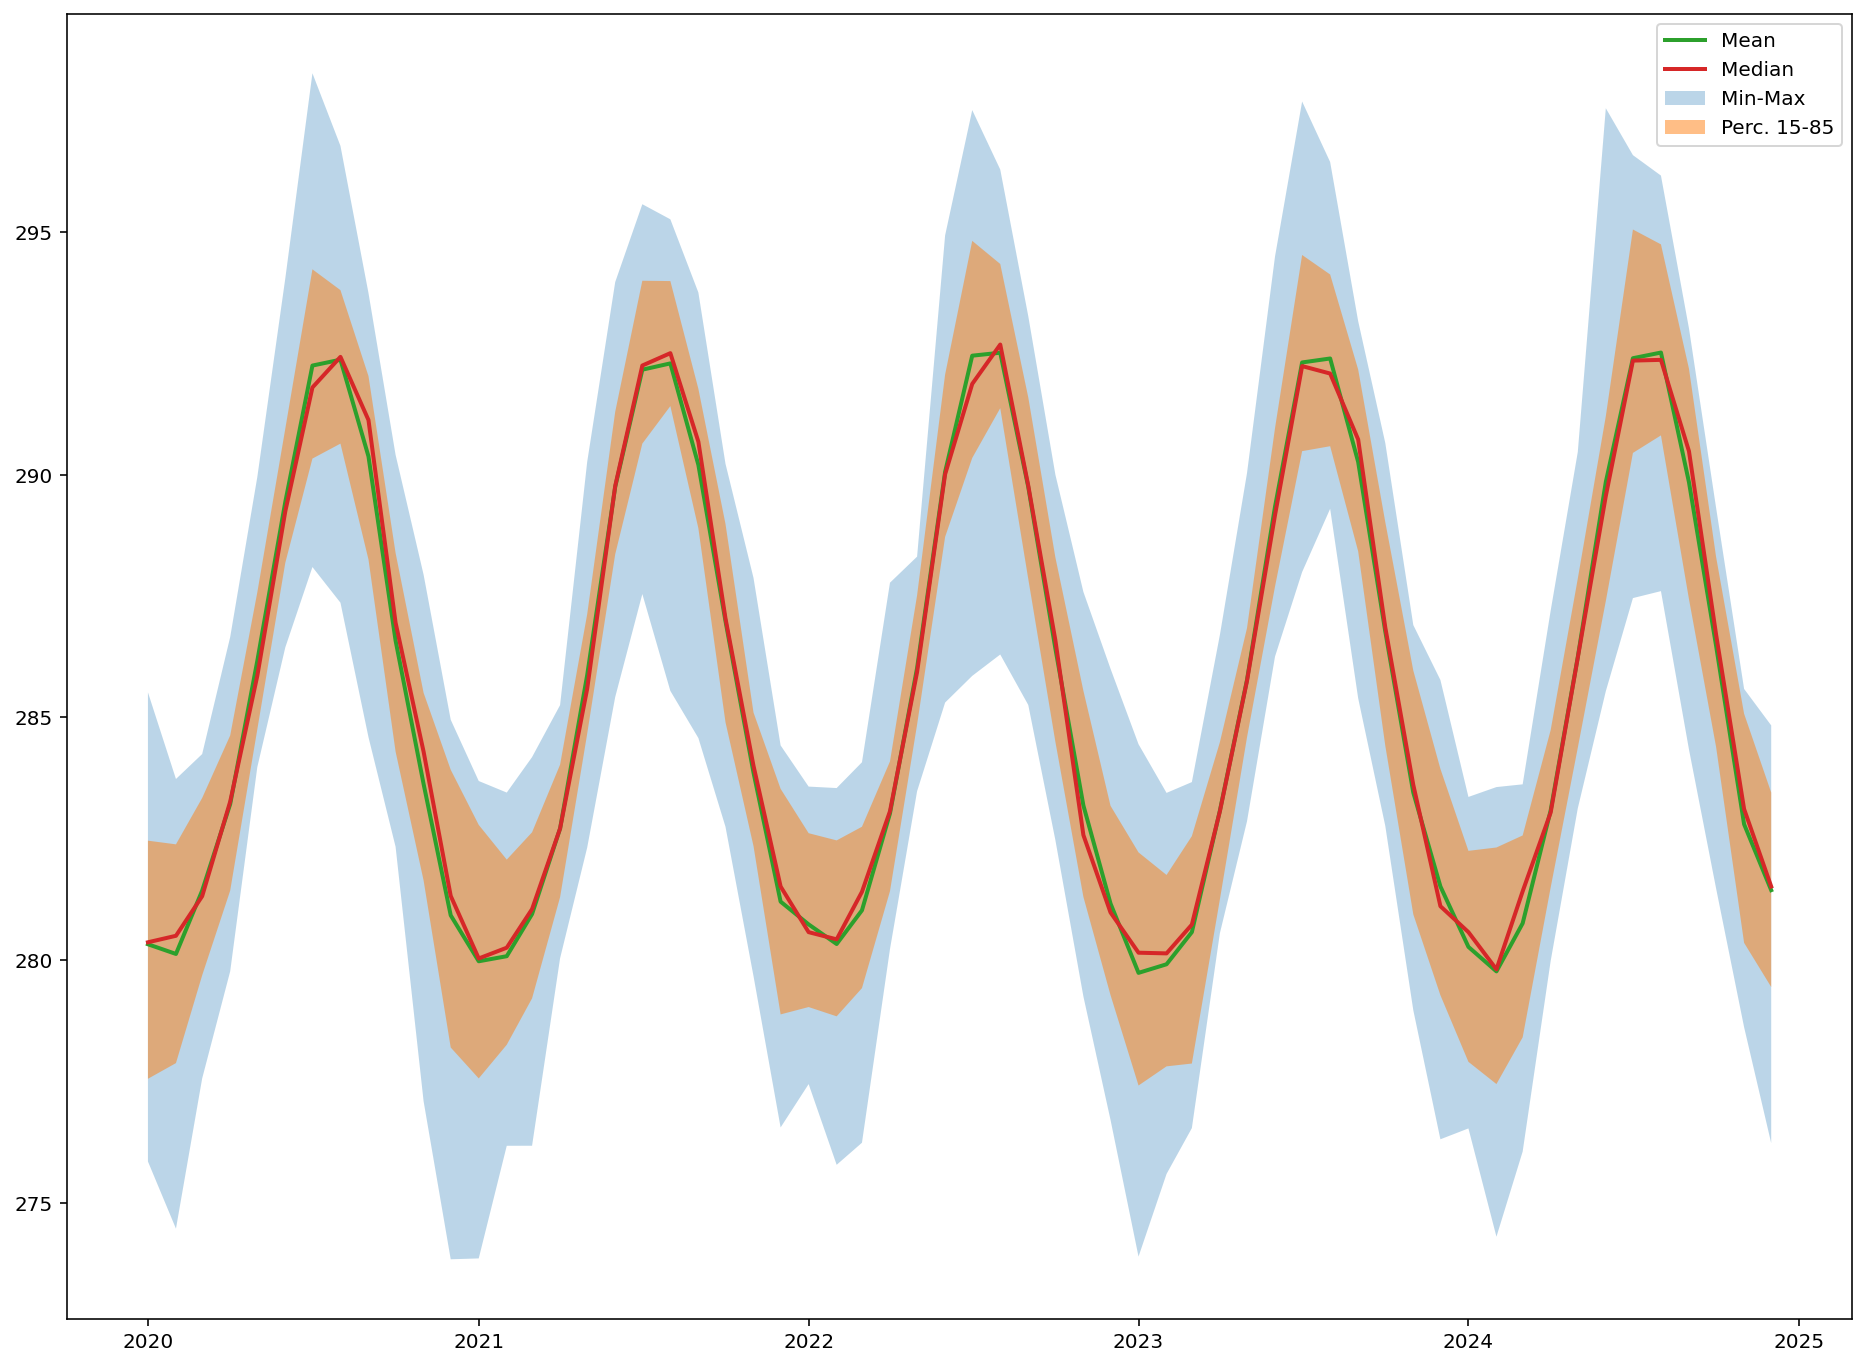

In [ ]:
fig, ax = plt.subplots(figsize=(16,12))
ax.fill_between(ens_stats.time.values,
                ens_stats.tas_min[0].values,
                ens_stats.tas_max[0].values,
                alpha=0.3,
                label='Min-Max')
ax.fill_between(ens_perc.time.values,
                ens_perc.tas.sel(percentiles=15)[0].values,
                ens_perc.tas.sel(percentiles=85)[0].values,
                alpha=0.5,
                label='Perc. 15-85')
ax._get_lines.get_next_color()  # Hack to get different line
ax._get_lines.get_next_color()
ax.plot(ens_stats.time.values,
        ens_stats.tas_mean[0].values,
        linewidth=2, label='Mean')
ax.plot(ens_perc.time.values,
        ens_perc.tas.sel(percentiles=50)[0].values,
        linewidth=2, label='Median')
ax.legend()
plt.show()



# End Script

In [ ]:
df_all = big_ds.to_dataframe().reset_index()
df_all.index = pd.DatetimeIndex(df_all.time.astype(str),name='indextime')
df_all

,bnds,experiment_id,source_id,time,tas
indextime,,,,,
1950-01-01,1.0,historical,ACCESS-CM2,1950-01-01 00:00:00,279.273926
1950-02-01,1.0,historical,ACCESS-CM2,1950-02-01 00:00:00,274.301025
1950-03-01,1.0,historical,ACCESS-CM2,1950-03-01 00:00:00,276.474121
1950-04-01,1.0,historical,ACCESS-CM2,1950-04-01 00:00:00,280.382080
1950-05-01,1.0,historical,ACCESS-CM2,1950-05-01 00:00:00,281.412598
...,...,...,...,...,...
2100-08-01,2.0,ssp585,NorESM2-MM,2100-08-01 00:00:00,298.291992
2100-09-01,2.0,ssp585,NorESM2-MM,2100-09-01 00:00:00,294.731079
2100-10-01,2.0,ssp585,NorESM2-MM,2100-10-01 00:00:00,290.043274


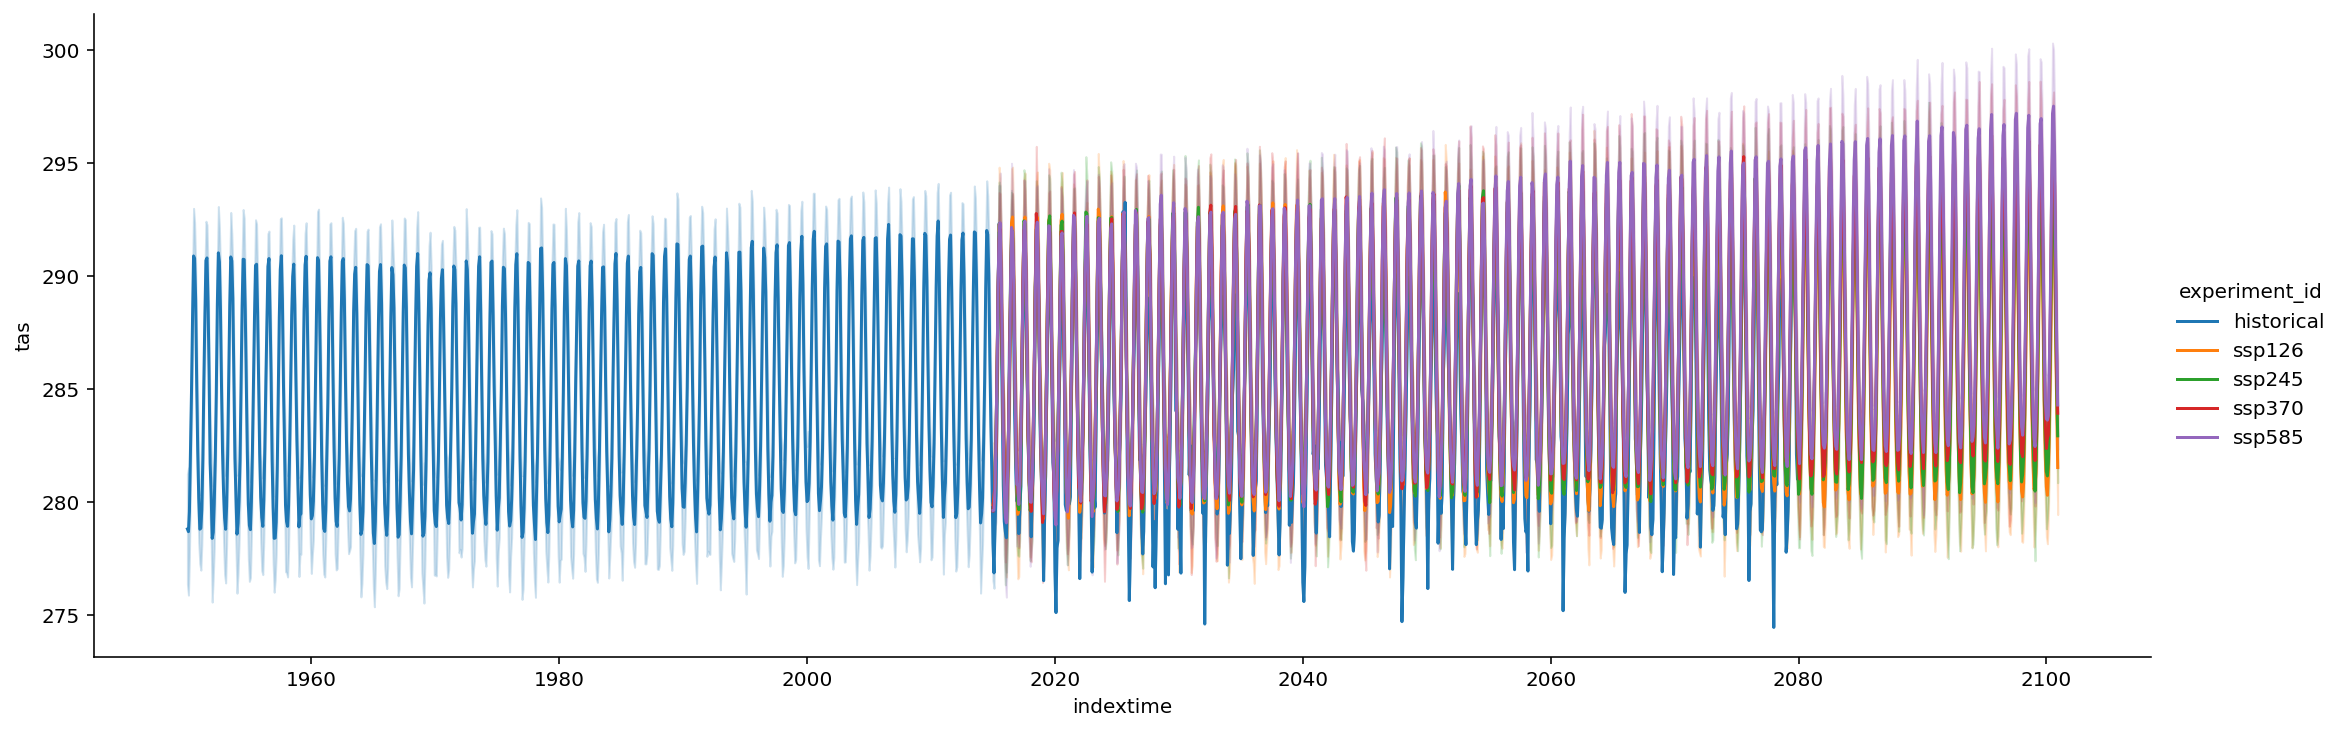

In [ ]:
sns.relplot(data=df_all,
            x="indextime", y="tas", hue='experiment_id',
            kind="line", ci="sd", aspect=3);

In [ ]:
ens = ensembles.create_ensemble(big_ds.tas)

ens

<xarray.Dataset>
Dimensions:        (experiment_id: 5, realization: 24, year: 451)
Coordinates:
    source_id      (realization) <U13 'ACCESS-CM2' ... 'NorESM2-MM'
  * year           (year) float64 1.85e+03 1.851e+03 ... 2.299e+03 2.3e+03
  * experiment_id  (experiment_id) <U10 'historical' 'ssp126' ... 'ssp585'
  * realization    (realization) int64 0 1 2 3 4 5 6 7 ... 17 18 19 20 21 22 23
Data variables:
    tas            (realization, experiment_id, year) float64 287.0 ... nan

/usr/local/lib/python3.6/dist-packages/xclim/ensembles.py:248: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  output_sizes={"percentiles": len(values)},


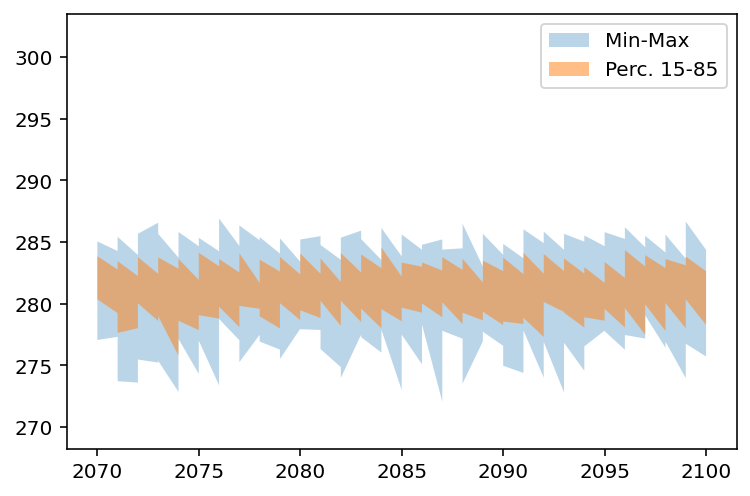

In [ ]:
# previous cells were pulled from the pangeo sample.
# the creation of the big_ds dataset is very efficient to work from
ens = ensembles.create_ensemble(big_ds.tas)

def plotset(ensemble,start,end,exp):
  ens = ens.sel(time=slice(start, end))
  ens = ens.sel(experiment_id=(exp))
  ens_perc = ensembles.ensemble_percentiles(ens, values=[15, 50, 85], split=False)
  ens_stats = ensembles.ensemble_mean_std_max_min(ens)

# def shiftfactor
